# Session Based Recommendation System

User - Item based recommendation system은 사용자에게 비슷한 선호도를 가진 사용자가 좋아하는 Item을 추천합니다. 그러나 상품 구매의 경우, 사용자는 늘 같은 부류의 상품을 구매하는 것이 아니고, 더욱 효과적인 추천을 위해서는 사용자가 현재 어떤 상품을 원하는지 알아야 할 것 같습니다.

따라서 한 세션(브라우저를 종료하기 전까지의 행동을 저장한 시퀀스 데이터)을 기반으로 추천시스템을 만들면 적절할 것입니다.



Movielens 1M Dataset으로 Session Based Recommendatation System을 구현합니다.

데이터 살펴보기

In [5]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [6]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [7]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [8]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [9]:
session_length.min(), session_length.max()

(20, 2314)

In [10]:
session_length.quantile(0.999)

1343.181000000005

In [11]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

In [12]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


이대로 Userid로 나눈 것이 Session으로 보기는 힘듭니다. 따라서 액션 간의 시차가 600초를 넘어선다면 세션을 나누어 보도록 합니다.

[pandas column 의 위아래 값의 차이를 비교해보자](https://jusths.tistory.com/38)


[unixtime to datetime](https://potensj.tistory.com/72)

In [13]:
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [14]:
datatemp = data.copy()

In [15]:
datatemp['Time_diff'] = datatemp['Time'].diff().fillna(0)
datatemp['Change_User'] = datatemp['UserId'].diff().fillna(0)

In [16]:
datatemp

,UserId,ItemId,Rating,Time,Time_diff,Change_User
31,1,3186,4,978300019,0.0,0.0
22,1,1270,5,978300055,36.0,0.0
27,1,1721,4,978300055,0.0,0.0
37,1,1022,5,978300055,0.0,0.0
24,1,2340,3,978300103,48.0,0.0
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,31.0,0.0
999988,6040,1921,4,997454464,35.0,0.0
1000172,6040,1784,3,997454464,0.0,0.0
1000167,6040,161,3,997454486,22.0,0.0


User의 변화와 Time의 변화를 기준으로 Session을 나눕니다

In [17]:
session_id = 1
def make_sessions(x):
    global session_id
    if x['Time_diff']>600 or x['Change_User']==1:
        session_id += 1
    return session_id

In [18]:
datatemp['SessionId'] = datatemp.apply(make_sessions, axis=1)

In [19]:
datatemp

,UserId,ItemId,Rating,Time,Time_diff,Change_User,SessionId
31,1,3186,4,978300019,0.0,0.0,1
22,1,1270,5,978300055,36.0,0.0,1
27,1,1721,4,978300055,0.0,0.0,1
37,1,1022,5,978300055,0.0,0.0,1
24,1,2340,3,978300103,48.0,0.0,1
...,...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,31.0,0.0,28378
999988,6040,1921,4,997454464,35.0,0.0,28378
1000172,6040,1784,3,997454464,0.0,0.0,28378
1000167,6040,161,3,997454486,22.0,0.0,28378


In [20]:
session_length = datatemp.groupby('SessionId').size()
session_length

SessionId
1         12
2         28
3         13
4        129
5         51
        ... 
28375      7
28376     14
28377      1
28378     21
28379      1
Length: 28379, dtype: int64

In [21]:
session_length.median(), session_length.mean()

(6.0, 35.244687973501534)

In [22]:
session_length.min(), session_length.max()

(1, 1193)

In [23]:
session_length.quantile(0.999)

683.1100000000151

In [24]:
session_length.describe(percentiles=[0.03, 0.28, 0.995])

count    28379.000000
mean        35.244688
std         72.348335
min          1.000000
3%           1.000000
28%          1.000000
50%          6.000000
99.5%      439.110000
max       1193.000000
dtype: float64

In [25]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.280101
2      0.383030
3      0.433701
4      0.467775
5      0.498467
         ...   
663    0.998802
670    0.998872
671    0.998908
674    0.998943
680    0.998978
Length: 507, dtype: float64

10분 간의 공백이 있는 것을 기준으로 세션을 나눌 경우, 28%의 세션이 길이 1을 가지게 된다. 기준을 더 길게 해 봅니다.

In [44]:
datatemp = data.copy()

In [27]:
datatemp['Time_diff'] = datatemp['Time'].diff().fillna(0)
datatemp['Change_User'] = datatemp['UserId'].diff().fillna(0)

In [28]:
datatemp

,UserId,ItemId,Rating,Time,Time_diff,Change_User
31,1,3186,4,978300019,0.0,0.0
22,1,1270,5,978300055,36.0,0.0
27,1,1721,4,978300055,0.0,0.0
37,1,1022,5,978300055,0.0,0.0
24,1,2340,3,978300103,48.0,0.0
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,31.0,0.0
999988,6040,1921,4,997454464,35.0,0.0
1000172,6040,1784,3,997454464,0.0,0.0
1000167,6040,161,3,997454486,22.0,0.0


User의 변화와 Time의 변화를 기준으로 Session을 나눕니다

In [29]:
session_id = 1
def make_sessions(x):
    global session_id
    if x['Time_diff']>3000 or x['Change_User']==1:
        session_id += 1
    return session_id

In [30]:
datatemp['SessionId'] = datatemp.apply(make_sessions, axis=1)

In [31]:
datatemp

,UserId,ItemId,Rating,Time,Time_diff,Change_User,SessionId
31,1,3186,4,978300019,0.0,0.0,1
22,1,1270,5,978300055,36.0,0.0,1
27,1,1721,4,978300055,0.0,0.0,1
37,1,1022,5,978300055,0.0,0.0,1
24,1,2340,3,978300103,48.0,0.0,1
...,...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,31.0,0.0,24558
999988,6040,1921,4,997454464,35.0,0.0,24558
1000172,6040,1784,3,997454464,0.0,0.0,24558
1000167,6040,161,3,997454486,22.0,0.0,24558


In [ ]:
session_length = datatemp.groupby('SessionId').size()
session_length

In [33]:
session_length.median(), session_length.mean()

(6.0, 40.726780406368334)

In [34]:
session_length.min(), session_length.max()

(1, 1290)

In [35]:
session_length.quantile(0.999)

768.0

In [36]:
session_length.describe(percentiles=[0.03, 0.28, 0.995])

count    24559.000000
mean        40.726780
std         81.880958
min          1.000000
3%           1.000000
28%          2.000000
50%          6.000000
99.5%      506.000000
max       1290.000000
dtype: float64

In [37]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.272731
2      0.373061
3      0.423185
4      0.455027
5      0.482064
         ...   
733    0.998778
735    0.998819
744    0.998860
761    0.998901
765    0.998941
Length: 538, dtype: float64

세션의 기준 길이를 10분으로 하든, 50분으로 하든, 길이가 1인 세션의 비율은 크게 변하지 않았습니다. 유효한 분포를 보기위해 같은 유저 내에서 Time_diff의 분포를 시각화해 보겠습니다.

In [38]:
effective_difference = datatemp[datatemp['Change_User']!=1]['Time_diff']

<AxesSubplot:ylabel='Frequency'>

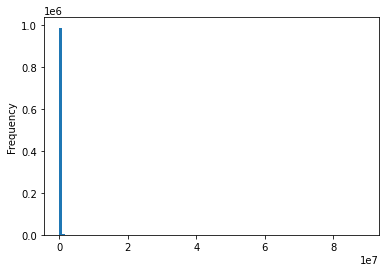

In [41]:
effective_difference.plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

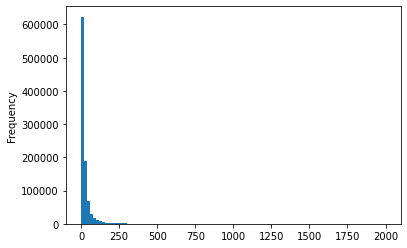

In [43]:
effective_difference[effective_difference<2000].plot.hist(bins=100)

200초를 기준으로 한다면 의미있는 세션을 잘 골라낼 수 있을 것 같습니다. 이후 길이가 3 미만인 세션은 삭제하도록 하겠습니다.

In [143]:
datatemp = data.copy()

datatemp['Time_diff'] = datatemp['Time'].diff().fillna(0)
datatemp['Change_User'] = datatemp['UserId'].diff().fillna(0)

session_id = 1
def make_sessions(x, max_diff):
    global session_id
    if x['Time_diff']>max_diff or x['Change_User']==1:
        session_id += 1
    return session_id

datatemp['SessionId'] = datatemp.apply(make_sessions, max_diff=200, axis=1)
session_length = datatemp.groupby('SessionId').size()

In [144]:
session_length

SessionId
1          7
2          5
3         28
4         13
5        129
        ... 
42314      6
42315     14
42316      1
42317     21
42318      1
Length: 42318, dtype: int64

In [145]:
effective_sessionid = session_length.apply(lambda g: g>=3)
print(effective_sessionid)
print(effective_sessionid.mean())

SessionId
1         True
2         True
3         True
4         True
5         True
         ...  
42314     True
42315     True
42316    False
42317     True
42318    False
Length: 42318, dtype: bool
0.6019188052365424


In [146]:
# 모든 value가 True 인 Series
sessionids = effective_sessionid[effective_sessionid==True]

In [147]:
session_list = sessionids.index.to_list()
len(session_list)

25472

In [148]:
clean_data = datatemp[datatemp['SessionId'].isin(session_list)]
clean_data

,UserId,ItemId,Rating,Time,Time_diff,Change_User,SessionId
31,1,3186,4,978300019,0.0,0.0,1
22,1,1270,5,978300055,36.0,0.0,1
27,1,1721,4,978300055,0.0,0.0,1
37,1,1022,5,978300055,0.0,0.0,1
24,1,2340,3,978300103,48.0,0.0,1
...,...,...,...,...,...,...,...
999923,6040,232,5,997454398,31.0,0.0,42317
1000019,6040,2917,4,997454429,31.0,0.0,42317
999988,6040,1921,4,997454464,35.0,0.0,42317
1000172,6040,1784,3,997454464,0.0,0.0,42317


전체 세션의 40%가 길이 1 혹은 2였습니다. 전체 데이터포인트에서 차지하는 비율은 5% 미만입니다.
전처리가 끝났으므로, Time_diff와 Change_User를 삭제하고 reindex합니다.

In [149]:
clean_data = clean_data[['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']]

In [150]:
clean_data.reset_index(drop=True, inplace=True)
clean_data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,1
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,1
...,...,...,...,...,...
978741,6040,232,5,997454398,42317
978742,6040,2917,4,997454429,42317
978743,6040,1921,4,997454464,42317
978744,6040,1784,3,997454464,42317


이제 시간을 datetime 형식으로 변환합니다.

In [156]:
def convert_datetime(unixtime):
    """Convert unixtime to datetime"""
    date = dt.datetime.fromtimestamp(unixtime).strftime('%Y-%m-%d %H:%M:%S')
    date = dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    return date # format : timestamp

In [157]:
clean_data['Time'] = clean_data.Time.apply(convert_datetime)

In [158]:
oldest, latest = clean_data['Time'].min(), clean_data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [159]:
session_length = clean_data.groupby('SessionId').size()
session_length

SessionId
1          7
2          5
3         28
4         13
5        129
        ... 
42311     19
42312     15
42314      6
42315     14
42317     21
Length: 25472, dtype: int64

In [160]:
session_length.median(), session_length.mean()

(14.0, 38.42438756281407)

In [161]:
session_length.min(), session_length.max()

(3, 1193)

In [162]:
session_length.quantile(0.999)

613.0580000000045

In [163]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

3      0.101837
4      0.170462
5      0.244425
6      0.300330
7      0.344417
         ...   
581    0.998783
587    0.998822
606    0.998861
610    0.998901
612    0.998979
Length: 440, dtype: float64

 위 분포를 시각화하면 다음과 같습니다.

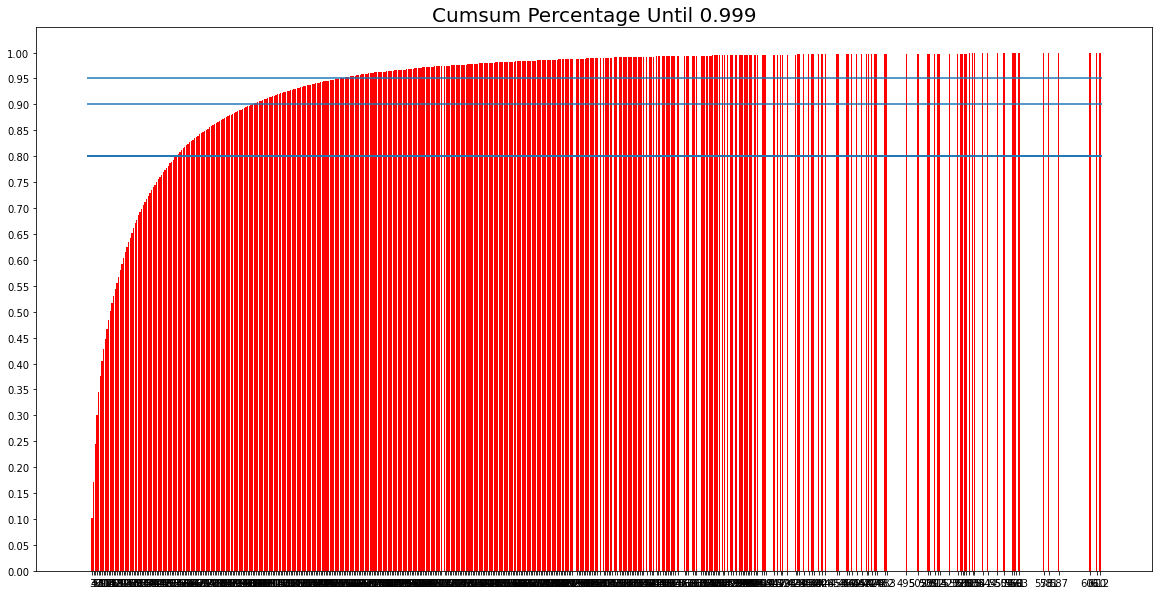

In [164]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.hlines(y=0.8, xmin=0, xmax=613)
plt.hlines(y=0.9, xmin=0, xmax=613)
plt.hlines(y=0.95, xmin=0, xmax=613)

plt.xticks(length_percent_cumsum_999.index)
plt.hlines(y=0.8, xmin=0, xmax=613)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.hlines(y=0.8, xmin=0, xmax=613)

plt.show()

누적합 0.95까지의 데이터를 사용합니다.

In [165]:
cumsum_95 = length_percent_cumsum_999[length_percent_cumsum_999<0.95]
cumsum_95

3      0.101837
4      0.170462
5      0.244425
6      0.300330
7      0.344417
         ...   
148    0.947001
149    0.947904
150    0.948453
151    0.949081
152    0.949827
Length: 150, dtype: float64

3부터 152까지의 데이터를 남깁니다.

In [166]:
effective_sessionid = session_length.apply(lambda g: 3<=g<=152)
print(effective_sessionid)
print(effective_sessionid.mean())

SessionId
1        True
2        True
3        True
4        True
5        True
         ... 
42311    True
42312    True
42314    True
42315    True
42317    True
Length: 25472, dtype: bool
0.9498272613065326


In [167]:
sessionids = effective_sessionid[effective_sessionid==True]
session_list = sessionids.index.to_list()
len(session_list)

24194

In [168]:
clean_data = clean_data[clean_data['SessionId'].isin(session_list)]
clean_data.reset_index(drop=True, inplace=True)
clean_data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,1
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,1
...,...,...,...,...,...
651036,6040,232,5,2001-08-10 14:39:58,42317
651037,6040,2917,4,2001-08-10 14:40:29,42317
651038,6040,1921,4,2001-08-10 14:41:04,42317
651039,6040,1784,3,2001-08-10 14:41:04,42317


이로서 200초를 기준으로 하는 세션에서, 3이상 152 이하의 액션 수를 보이는 세션만 선택되었습니다.

In [169]:
oldest, latest = clean_data['Time'].min(), clean_data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [170]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

영화 리뷰이고, train_set을 15개월, validation_set을 3개월,  test_set을 2개월로 설정합니다. 1개월은 30일.

In [221]:
start_timestamp = latest - dt.timedelta(30*20)     # 최종 날짜로부터 17개월 이전 날짜를 구한다.  
datasets = clean_data[clean_data['Time'] > start_timestamp]   # 방금 구한 날짜 이후의 데이터만 모은다. 
#data

In [222]:
datasets

,UserId,ItemId,Rating,Time,SessionId
1732,20,1694,3,2001-12-29 23:37:51,82
1733,20,1468,3,2001-12-29 23:37:51,82
1734,20,3717,2,2001-12-29 23:37:51,82
1735,20,2858,4,2001-12-29 23:37:51,82
1736,20,2641,4,2001-12-29 23:38:35,82
...,...,...,...,...,...
651036,6040,232,5,2001-08-10 14:39:58,42317
651037,6040,2917,4,2001-08-10 14:40:29,42317
651038,6040,1921,4,2001-08-10 14:41:04,42317
651039,6040,1784,3,2001-08-10 14:41:04,42317


평점이 3 이상인 것만 남깁니다.

In [223]:
datasets = datasets[datasets['Rating']>=3]

In [224]:
datasets

,UserId,ItemId,Rating,Time,SessionId
1732,20,1694,3,2001-12-29 23:37:51,82
1733,20,1468,3,2001-12-29 23:37:51,82
1735,20,2858,4,2001-12-29 23:37:51,82
1736,20,2641,4,2001-12-29 23:38:35,82
1737,20,1375,3,2001-12-29 23:38:35,82
...,...,...,...,...,...
651036,6040,232,5,2001-08-10 14:39:58,42317
651037,6040,2917,4,2001-08-10 14:40:29,42317
651038,6040,1921,4,2001-08-10 14:41:04,42317
651039,6040,1784,3,2001-08-10 14:41:04,42317


data cleansing

In [225]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [226]:
# least_click의 경우 rating의 최소 개수를 의미합니다.
cleansed_datasets = cleanse_recursive(datasets, shortest=3, least_click=20)
cleansed_datasets

,UserId,ItemId,Rating,Time,SessionId
1735,20,2858,4,2001-12-29 23:37:51,82
1737,20,1375,3,2001-12-29 23:38:35,82
1738,20,3753,5,2001-12-29 23:38:36,82
1739,20,3527,4,2001-12-29 23:39:41,82
1740,20,1527,5,2001-12-29 23:39:41,82
...,...,...,...,...,...
651034,6040,457,4,2001-08-10 14:39:09,42317
651035,6040,3671,4,2001-08-10 14:39:27,42317
651038,6040,1921,4,2001-08-10 14:41:04,42317
651039,6040,1784,3,2001-08-10 14:41:04,42317


마지막으로,  index를 reset하고, SessionId역시 0부터 다시 시작하도록 합니다.

In [228]:
cleansed_datasets.reset_index(drop=True, inplace=True)
cleansed_datasets['Session_change'] = cleansed_datasets['SessionId'].diff().fillna(0)

new_session_id = 0
def reset_sessions(x):
    global new_session_id
    if x['Session_change']:
        new_session_id += 1
    return new_session_id
         
cleansed_datasets['SessionId'] = cleansed_datasets.apply(reset_sessions, axis=1)
cleansed_datasets = cleansed_datasets[['ItemId', 'Time', 'SessionId']]
cleansed_datasets

,ItemId,Time,SessionId
0,2858,2001-12-29 23:37:51,0
1,1375,2001-12-29 23:38:35,0
2,3753,2001-12-29 23:38:36,0
3,3527,2001-12-29 23:39:41,0
4,1527,2001-12-29 23:39:41,0
...,...,...,...
11553,457,2001-08-10 14:39:09,1251
11554,3671,2001-08-10 14:39:27,1251
11555,1921,2001-08-10 14:41:04,1251
11556,1784,2001-08-10 14:41:04,1251


In [229]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [230]:
tr, test = split_by_date(cleansed_datasets, n_days=60)
tr, val = split_by_date(tr, n_days=90)

In [231]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [232]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 9742
	 Sessions: 1056
	 Items: 362
	 First Time : 2001-07-08 19:44:06
	 Last Time : 2002-09-29 23:16:00

* valid Set Stats Info
	 Events: 929
	 Sessions: 107
	 Items: 329
	 First Time : 2002-10-05 02:21:48
	 Last Time : 2002-12-29 04:39:37

* test Set Stats Info
	 Events: 887
	 Sessions: 89
	 Items: 328
	 First Time : 2002-12-29 20:57:38
	 Last Time : 2003-02-27 18:17:38



분할을 마쳤습니다.

In [283]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [284]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [285]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [286]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,ItemId,Time,SessionId,item_idx
0,2858,2001-12-29 23:37:51,0,0
1,1375,2001-12-29 23:38:35,0,1
2,3753,2001-12-29 23:38:36,0,2
3,3527,2001-12-29 23:39:41,0,3
4,1527,2001-12-29 23:39:41,0,4
5,1240,2001-12-29 23:39:41,0,5
6,1371,2001-12-29 23:40:27,0,6
7,1387,2002-03-12 03:46:59,1,7
8,1201,2002-03-12 03:46:59,1,8
9,1291,2002-03-12 03:47:16,1,9


In [287]:
tr_dataset.click_offsets

array([   0,    7,   12, ..., 9718, 9730, 9742], dtype=int32)

In [288]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 1053, 1054, 1055])

In [289]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

# Modeling
evaluation metric을 정의하고, model을 설계합니다.

In [290]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [291]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm


def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [296]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1,\
            lr=0.001, epochs=100, k=20)

In [297]:
model = create_model(args)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(32, 1, 362)]            0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      62100     
_________________________________________________________________
dropout_9 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_9 (Dense)              (32, 362)                 18462     
Total params: 80,562
Trainable params: 80,562
Non-trainable params: 0
_________________________________________________________________


In [335]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.
        yield {"val_recall": val_recall}
        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [299]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.86]

	 - Recall@20 epoch 1: 0.097426
	 - MRR@20    epoch 1: 0.015208



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0, train_loss=5.87]     

	 - Recall@20 epoch 2: 0.104779
	 - MRR@20    epoch 2: 0.021540



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0, train_loss=5.65]     

	 - Recall@20 epoch 3: 0.130515
	 - MRR@20    epoch 3: 0.035653



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0, train_loss=5.48]     

	 - Recall@20 epoch 4: 0.143382
	 - MRR@20    epoch 4: 0.046570



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0, train_loss=5.41]     

	 - Recall@20 epoch 5: 0.154412
	 - MRR@20    epoch 5: 0.049442



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0, train_loss=5.22]     

	 - Recall@20 epoch 6: 0.158088
	 - MRR@20    epoch 6: 0.054800



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.09]

	 - Recall@20 epoch 7: 0.180147
	 - MRR@20    epoch 7: 0.053833



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0, train_loss=5]        

	 - Recall@20 epoch 8: 0.193015
	 - MRR@20    epoch 8: 0.054332



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.13]

	 - Recall@20 epoch 9: 0.204044
	 - MRR@20    epoch 9: 0.057127



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0312, train_loss=4.73]

	 - Recall@20 epoch 10: 0.200368
	 - MRR@20    epoch 10: 0.060229



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0312, train_loss=4.65]

	 - Recall@20 epoch 11: 0.205882
	 - MRR@20    epoch 11: 0.063426



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0312, train_loss=4.57]

	 - Recall@20 epoch 12: 0.211397
	 - MRR@20    epoch 12: 0.065062



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.52]

	 - Recall@20 epoch 13: 0.202206
	 - MRR@20    epoch 13: 0.066488



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.38]

	 - Recall@20 epoch 14: 0.207721
	 - MRR@20    epoch 14: 0.068303



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.32]

	 - Recall@20 epoch 15: 0.204044
	 - MRR@20    epoch 15: 0.069317



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.26] 

	 - Recall@20 epoch 16: 0.204044
	 - MRR@20    epoch 16: 0.070868



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.26] 

	 - Recall@20 epoch 17: 0.194853
	 - MRR@20    epoch 17: 0.069788



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.22]

	 - Recall@20 epoch 18: 0.202206
	 - MRR@20    epoch 18: 0.068478



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.4] 

	 - Recall@20 epoch 19: 0.200368
	 - MRR@20    epoch 19: 0.069302



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.05] 

	 - Recall@20 epoch 20: 0.196691
	 - MRR@20    epoch 20: 0.069153



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.84] 

	 - Recall@20 epoch 21: 0.193015
	 - MRR@20    epoch 21: 0.069278



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.75] 

	 - Recall@20 epoch 22: 0.187500
	 - MRR@20    epoch 22: 0.069395



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.04] 

	 - Recall@20 epoch 23: 0.193015
	 - MRR@20    epoch 23: 0.069182



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.188, train_loss=4.03] 

	 - Recall@20 epoch 24: 0.183824
	 - MRR@20    epoch 24: 0.068831



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.77] 

	 - Recall@20 epoch 25: 0.178309
	 - MRR@20    epoch 25: 0.068539



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0938, train_loss=3.96]

	 - Recall@20 epoch 26: 0.187500
	 - MRR@20    epoch 26: 0.067870



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.71] 

	 - Recall@20 epoch 27: 0.183824
	 - MRR@20    epoch 27: 0.065650



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.76] 

	 - Recall@20 epoch 28: 0.185662
	 - MRR@20    epoch 28: 0.065690



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.156, train_loss=3.69] 

	 - Recall@20 epoch 29: 0.193015
	 - MRR@20    epoch 29: 0.066350



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.5]  

	 - Recall@20 epoch 30: 0.185662
	 - MRR@20    epoch 30: 0.066362



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.219, train_loss=3.57] 

	 - Recall@20 epoch 31: 0.185662
	 - MRR@20    epoch 31: 0.066379



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0938, train_loss=3.78]

	 - Recall@20 epoch 32: 0.185662
	 - MRR@20    epoch 32: 0.065438



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.219, train_loss=3.6]  

	 - Recall@20 epoch 33: 0.185662
	 - MRR@20    epoch 33: 0.064844



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0938, train_loss=3.72]

	 - Recall@20 epoch 34: 0.178309
	 - MRR@20    epoch 34: 0.064794



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.219, train_loss=3.36] 

	 - Recall@20 epoch 35: 0.172794
	 - MRR@20    epoch 35: 0.064483



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.219, train_loss=3.48] 

	 - Recall@20 epoch 36: 0.170956
	 - MRR@20    epoch 36: 0.064379



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0938, train_loss=3.66]

	 - Recall@20 epoch 37: 0.169118
	 - MRR@20    epoch 37: 0.064376



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.219, train_loss=3.35] 

	 - Recall@20 epoch 38: 0.172794
	 - MRR@20    epoch 38: 0.063215



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.156, train_loss=3.41] 

	 - Recall@20 epoch 39: 0.167279
	 - MRR@20    epoch 39: 0.061906



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.31] 

	 - Recall@20 epoch 40: 0.172794
	 - MRR@20    epoch 40: 0.063887



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.51]

	 - Recall@20 epoch 41: 0.170956
	 - MRR@20    epoch 41: 0.062477



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.344, train_loss=3.1] 

	 - Recall@20 epoch 42: 0.170956
	 - MRR@20    epoch 42: 0.063191



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.89]

	 - Recall@20 epoch 43: 0.167279
	 - MRR@20    epoch 43: 0.061728



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.22] 

	 - Recall@20 epoch 44: 0.169118
	 - MRR@20    epoch 44: 0.061603



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.19] 

	 - Recall@20 epoch 45: 0.169118
	 - MRR@20    epoch 45: 0.061378



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.312, train_loss=3.11]

	 - Recall@20 epoch 46: 0.165441
	 - MRR@20    epoch 46: 0.061224



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.219, train_loss=3.09]

	 - Recall@20 epoch 47: 0.172794
	 - MRR@20    epoch 47: 0.059659



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.06]

	 - Recall@20 epoch 48: 0.172794
	 - MRR@20    epoch 48: 0.059835



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.91] 

	 - Recall@20 epoch 49: 0.170956
	 - MRR@20    epoch 49: 0.060374



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0938, train_loss=3.39]

	 - Recall@20 epoch 50: 0.180147
	 - MRR@20    epoch 50: 0.060233



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.156, train_loss=3.09]

	 - Recall@20 epoch 51: 0.176471
	 - MRR@20    epoch 51: 0.059493



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.219, train_loss=3.13]

	 - Recall@20 epoch 52: 0.180147
	 - MRR@20    epoch 52: 0.060619



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.312, train_loss=2.8] 

	 - Recall@20 epoch 53: 0.178309
	 - MRR@20    epoch 53: 0.058027



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.406, train_loss=2.49]

	 - Recall@20 epoch 54: 0.180147
	 - MRR@20    epoch 54: 0.056917



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.156, train_loss=3.12]

	 - Recall@20 epoch 55: 0.178309
	 - MRR@20    epoch 55: 0.057789



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.16]

	 - Recall@20 epoch 56: 0.178309
	 - MRR@20    epoch 56: 0.056074



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.281, train_loss=2.99]

	 - Recall@20 epoch 57: 0.174632
	 - MRR@20    epoch 57: 0.058026



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.281, train_loss=3.21]

	 - Recall@20 epoch 58: 0.174632
	 - MRR@20    epoch 58: 0.056350



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.219, train_loss=3.13]

	 - Recall@20 epoch 59: 0.180147
	 - MRR@20    epoch 59: 0.055617



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.312, train_loss=2.44]

	 - Recall@20 epoch 60: 0.172794
	 - MRR@20    epoch 60: 0.056285



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.78] 

	 - Recall@20 epoch 61: 0.172794
	 - MRR@20    epoch 61: 0.056181



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.6]  

	 - Recall@20 epoch 62: 0.172794
	 - MRR@20    epoch 62: 0.055369



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.281, train_loss=2.84]

	 - Recall@20 epoch 63: 0.174632
	 - MRR@20    epoch 63: 0.053378



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.344, train_loss=2.47]

	 - Recall@20 epoch 64: 0.174632
	 - MRR@20    epoch 64: 0.054370



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.281, train_loss=2.72]

	 - Recall@20 epoch 65: 0.172794
	 - MRR@20    epoch 65: 0.055201



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.95] 

	 - Recall@20 epoch 66: 0.169118
	 - MRR@20    epoch 66: 0.054176



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.312, train_loss=2.63]

	 - Recall@20 epoch 67: 0.172794
	 - MRR@20    epoch 67: 0.053866



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.344, train_loss=2.65]

	 - Recall@20 epoch 68: 0.174632
	 - MRR@20    epoch 68: 0.053989



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.406, train_loss=2.37]

	 - Recall@20 epoch 69: 0.176471
	 - MRR@20    epoch 69: 0.053518



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.188, train_loss=2.78]

	 - Recall@20 epoch 70: 0.174632
	 - MRR@20    epoch 70: 0.051127



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.281, train_loss=2.65]

	 - Recall@20 epoch 71: 0.178309
	 - MRR@20    epoch 71: 0.051079



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.53]

	 - Recall@20 epoch 72: 0.178309
	 - MRR@20    epoch 72: 0.053327



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.344, train_loss=2.7] 

	 - Recall@20 epoch 73: 0.170956
	 - MRR@20    epoch 73: 0.051741



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.156, train_loss=2.78]

	 - Recall@20 epoch 74: 0.169118
	 - MRR@20    epoch 74: 0.053871



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.406, train_loss=2.34]

	 - Recall@20 epoch 75: 0.172794
	 - MRR@20    epoch 75: 0.052512



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.312, train_loss=2.54]

	 - Recall@20 epoch 76: 0.169118
	 - MRR@20    epoch 76: 0.051878



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.281, train_loss=2.7] 

	 - Recall@20 epoch 77: 0.170956
	 - MRR@20    epoch 77: 0.054139



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.312, train_loss=2.61]

	 - Recall@20 epoch 78: 0.174632
	 - MRR@20    epoch 78: 0.051571



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.406, train_loss=2.71]

	 - Recall@20 epoch 79: 0.170956
	 - MRR@20    epoch 79: 0.050605



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.312, train_loss=2.53]

	 - Recall@20 epoch 80: 0.169118
	 - MRR@20    epoch 80: 0.049674



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.344, train_loss=2.42]

	 - Recall@20 epoch 81: 0.169118
	 - MRR@20    epoch 81: 0.048707



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.312, train_loss=2.24]

	 - Recall@20 epoch 82: 0.170956
	 - MRR@20    epoch 82: 0.049865



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.406, train_loss=2.1] 

	 - Recall@20 epoch 83: 0.174632
	 - MRR@20    epoch 83: 0.049268



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.344, train_loss=2.19]

	 - Recall@20 epoch 84: 0.161765
	 - MRR@20    epoch 84: 0.049287



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.4]   

	 - Recall@20 epoch 85: 0.167279
	 - MRR@20    epoch 85: 0.049627



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.281, train_loss=2.63]

	 - Recall@20 epoch 86: 0.170956
	 - MRR@20    epoch 86: 0.050378



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.344, train_loss=2.58]

	 - Recall@20 epoch 87: 0.169118
	 - MRR@20    epoch 87: 0.050693



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.344, train_loss=2.49]

	 - Recall@20 epoch 88: 0.161765
	 - MRR@20    epoch 88: 0.051210



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.438, train_loss=2.24]

	 - Recall@20 epoch 89: 0.163603
	 - MRR@20    epoch 89: 0.051151



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.406, train_loss=2.04]

	 - Recall@20 epoch 90: 0.163603
	 - MRR@20    epoch 90: 0.049774



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.43]

	 - Recall@20 epoch 91: 0.163603
	 - MRR@20    epoch 91: 0.050903



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.344, train_loss=2.34]

	 - Recall@20 epoch 92: 0.161765
	 - MRR@20    epoch 92: 0.051943



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.438, train_loss=2.26]

	 - Recall@20 epoch 93: 0.161765
	 - MRR@20    epoch 93: 0.051303



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.01]

	 - Recall@20 epoch 94: 0.163603
	 - MRR@20    epoch 94: 0.053668



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.344, train_loss=2.13]

	 - Recall@20 epoch 95: 0.163603
	 - MRR@20    epoch 95: 0.052210



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.438, train_loss=2.53]

	 - Recall@20 epoch 96: 0.156250
	 - MRR@20    epoch 96: 0.051414



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.312, train_loss=2.54]

	 - Recall@20 epoch 97: 0.163603
	 - MRR@20    epoch 97: 0.052858



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.97]  

	 - Recall@20 epoch 98: 0.154412
	 - MRR@20    epoch 98: 0.051298



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.406, train_loss=2.09]

	 - Recall@20 epoch 99: 0.154412
	 - MRR@20    epoch 99: 0.051468



Evaluation:  68%|██████▊   | 17/25 [00:03<00:01,  5.04it/s]

	 - Recall@20 epoch 100: 0.158088
	 - MRR@20    epoch 100: 0.052648



In [300]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  54%|█████▍    | 13/24 [00:02<00:02,  5.16it/s]

	 - Recall@20: 0.213942
	 - MRR@20: 0.056785



첫번째 시도의 경우 0.21의 Recall@20을 얻었습니다. 이제 epoch숫자를 줄여서 다시 해보겠습니다.

In [302]:
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1,\
            lr=0.001, epochs=12, k=20)
model = create_model(args)
train_model(model, args)

Train:   0%|          | 0/271 [00:00<?, ?it/s]

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(32, 1, 362)]            0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      62100     
_________________________________________________________________
dropout_10 (Dropout)         (32, 50)                  0         
_________________________________________________________________
dense_10 (Dense)             (32, 362)                 18462     
Total params: 80,562
Trainable params: 80,562
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0, train_loss=5.87]     

	 - Recall@20 epoch 1: 0.095588
	 - MRR@20    epoch 1: 0.015361



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0, train_loss=5.72]     

	 - Recall@20 epoch 2: 0.101103
	 - MRR@20    epoch 2: 0.019520



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.65]

	 - Recall@20 epoch 3: 0.123162
	 - MRR@20    epoch 3: 0.033189



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0, train_loss=5.72]     

	 - Recall@20 epoch 4: 0.139706
	 - MRR@20    epoch 4: 0.044038



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.37]

	 - Recall@20 epoch 5: 0.156250
	 - MRR@20    epoch 5: 0.053281



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.21]

	 - Recall@20 epoch 6: 0.174632
	 - MRR@20    epoch 6: 0.058223



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.16]

	 - Recall@20 epoch 7: 0.180147
	 - MRR@20    epoch 7: 0.061480



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.26]

	 - Recall@20 epoch 8: 0.191176
	 - MRR@20    epoch 8: 0.062361



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0312, train_loss=4.99]

	 - Recall@20 epoch 9: 0.204044
	 - MRR@20    epoch 9: 0.065201



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.08]

	 - Recall@20 epoch 10: 0.213235
	 - MRR@20    epoch 10: 0.067857



Train:   0%|          | 0/271 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.57] 

	 - Recall@20 epoch 11: 0.216912
	 - MRR@20    epoch 11: 0.068627



Evaluation:  68%|██████▊   | 17/25 [00:03<00:01,  5.11it/s]

	 - Recall@20 epoch 12: 0.211397
	 - MRR@20    epoch 12: 0.069721



In [303]:
test_model(model, args, test)

Evaluation:  54%|█████▍    | 13/24 [00:02<00:02,  5.18it/s]

	 - Recall@20: 0.240385
	 - MRR@20: 0.079802



epoch을 적절히 조절하니 더 좋은 결과가 나왔습니다.
이것을 베이스라인으로 하여 하이퍼파라미터 피팅을 시도합니다.

In [304]:
pip install ray[tune]

     |████████████████████████████████| 124 kB 9.5 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [314]:
from ray import tune
from ray.tune import JupyterNotebookReporter
import ray

In [393]:
class TuneReporterCallback(tf.keras.callbacks.Callback):
    """Tune Callback for Keras.
    
    The callback is invoked every epoch.
    """

    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()

    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        tune.report(keras_info=logs, val_recall=logs.get("val_recall"))

In [413]:
def train_model(model, args):
        train_dataset = SessionDataset(args.tr)
        train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)
        old_val_recall = 0

        for epoch in range(1, args.epochs + 1):
            total_step = len(args.tr) - args.tr['SessionId'].nunique()
            tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
            for feat, target, mask in tr_loader:
                reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

                input_ohe = to_categorical(feat, num_classes=args.num_items)
                input_ohe = np.expand_dims(input_ohe, axis=1)
                target_ohe = to_categorical(target, num_classes=args.num_items)

                result = model.train_on_batch(input_ohe, target_ohe)
                tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

            val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.
            print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
            print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")
            if old_val_recall > val_recall:
                break
            old_val_recall = val_recall
            tune.report(val_recall=val_recall)
            

In [414]:
def tune_model(config):
    batch_size, drop_rate, lr = config['batch_size'], config['drop_rate'], config['lr']
    
    args = Args(tr, val, test, lr=lr, batch_size=batch_size, drop_rate=drop_rate,\
             epochs=20, k=20, hsz=50)
    model = create_model(args)
    train_model(model,args)

In [415]:
hyperparameter_space = {
    "lr": tune.loguniform(1e-4, 1e-2),  
    "batch_size": tune.choice([16, 32, 64]),
    "drop_rate": tune.uniform(0.05, 0.15),
    "num_gpus": 1
}

In [416]:
from ray.tune.schedulers import ASHAScheduler

num_samples = 120

In [417]:
RAY_USE_MULTIPROCESSING_CPU_COUNT=1
reporter = JupyterNotebookReporter(overwrite=True)
reporter.add_metric_column("val_recall")


ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)
# We clean out the logs before running for a clean visualization later.
! rm -rf ~/aiffel/000Projects/EX12/ray_results

asha_scheduler = ASHAScheduler(
    max_t=100,
    grace_period=3,
    reduction_factor=3,
    brackets=1)


analysis = ray.tune.run(
    tune_model,
    metric="val_recall",
    mode='max',
    verbose=3, 
    config=hyperparameter_space,
    num_samples=num_samples,
    resources_per_trial={"cpu": 4, "gpu": 1},
    progress_reporter=reporter,
    local_dir="~/aiffel/000Projects/EX12/ray_results",
    scheduler=asha_scheduler
    )

assert len(analysis.trials) == num_samples, "Did you set the correct number of samples?"

Trial name,status,loc,batch_size,drop_rate,lr,iter,total time (s),val_recall
tune_model_d1ba6_00000,TERMINATED,,64,0.0589745,0.000971144,1,5.34816,0.0911458
tune_model_d1ba6_00001,TERMINATED,,64,0.116097,0.00375473,5,18.377,0.1875
tune_model_d1ba6_00002,TERMINATED,,64,0.142528,0.00107687,1,5.32112,0.0911458
tune_model_d1ba6_00003,TERMINATED,,64,0.137419,0.00338985,3,11.8075,0.153646
tune_model_d1ba6_00004,TERMINATED,,64,0.141975,0.000326932,3,12.0233,0.0989583
tune_model_d1ba6_00005,TERMINATED,,64,0.0615802,0.00435473,4,15.1256,0.184896
tune_model_d1ba6_00006,TERMINATED,,32,0.0754772,0.000376425,2,13.0658,0.117647
tune_model_d1ba6_00007,TERMINATED,,32,0.0748212,0.000543971,1,7.40337,0.108456
tune_model_d1ba6_00008,TERMINATED,,16,0.104406,0.00113166,3,26.9863,0.155449
tune_model_d1ba6_00009,TERMINATED,,64,0.0558955,0.000315286,3,12.2698,0.0859375


2021-08-31 09:46:24,838	INFO tune.py:448 -- Total run time: 2785.89 seconds (2785.83 seconds for the tuning loop).


In [418]:
analysis.best_config

{'lr': 0.0012754522124088456,
 'batch_size': 16,
 'drop_rate': 0.12611316710848264,
 'num_gpus': 1}

120가지 조합을 한 결과 얻은 최적의 하이퍼파라미터입니다.학습시켜보겠습니다.

In [421]:
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.
        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")

In [424]:
best_args = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.12611316710848264,\
            lr=0.0012754522124088456, epochs=8, k=20)

In [425]:
best_model = create_model(best_args)
train_model(best_model,best_args)

Train:   0%|          | 0/542 [00:00<?, ?it/s]

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(16, 1, 362)]            0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      62100     
_________________________________________________________________
dropout_12 (Dropout)         (16, 50)                  0         
_________________________________________________________________
dense_12 (Dense)             (16, 362)                 18462     
Total params: 80,562
Trainable params: 80,562
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/542 [00:00<?, ?it/s, accuracy=0, train_loss=5.72]     

	 - Recall@20 epoch 1: 0.091346
	 - MRR@20    epoch 1: 0.016013



Train:   0%|          | 0/542 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.77]

	 - Recall@20 epoch 2: 0.115385
	 - MRR@20    epoch 2: 0.032200



Train:   0%|          | 0/542 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.18]

	 - Recall@20 epoch 3: 0.166667
	 - MRR@20    epoch 3: 0.041933



Train:   0%|          | 0/542 [00:00<?, ?it/s, accuracy=0.188, train_loss=4.9]  

	 - Recall@20 epoch 4: 0.198718
	 - MRR@20    epoch 4: 0.052643



Train:   0%|          | 0/542 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.15] 

	 - Recall@20 epoch 5: 0.205128
	 - MRR@20    epoch 5: 0.056408



Train:   0%|          | 0/542 [00:00<?, ?it/s, accuracy=0.188, train_loss=4.33] 

	 - Recall@20 epoch 6: 0.211538
	 - MRR@20    epoch 6: 0.061279



Train:   0%|          | 0/542 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.71]

	 - Recall@20 epoch 7: 0.211538
	 - MRR@20    epoch 7: 0.062015



Evaluation:  76%|███████▋  | 39/51 [00:04<00:01,  8.66it/s]

	 - Recall@20 epoch 8: 0.214744
	 - MRR@20    epoch 8: 0.061703



In [426]:
test_model(best_model, best_args, test)

Evaluation:  78%|███████▊  | 38/49 [00:04<00:01,  8.93it/s]

	 - Recall@20: 0.268092
	 - MRR@20: 0.089813



## 최종 Recall@20: 0.268, 최종 MRR@20: 0.0898

## 회고
1️⃣ 잘한 점:

세션 정의를 현실과 맞게 해서  잘 나누었다고 생각한다. 어떻게 좋은 평가지표를 받았는지 조원과 공유했다.

2️⃣ 어려웠던 점:

ray로 원하는 동작을 하게 만드는 것이 매우 어려웠다
세션을 나눌 때, 엔지니어의 직관이 들어가는 것처럼 도메인 지식이 어느 영역에서든 매우 중요할 것 같은데,
영화 리뷰나 온라인 쇼핑에 대해 아는 것이 없어 어려웠다.


3️⃣ 느낀 점:

이 평가 지표가 높으면 해당 세션의 정의에선 분명히 예측을 잘 한 것이다. 그러나, 실제 모델의 효과는  세션 정의를 어떻게 하냐에 따라 달라질 것이라고 생각한다.